<a href="https://colab.research.google.com/github/MiroPol21/dspracticum2025/blob/main/lesson02/Own_images_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's build a simple neural network to classify images.

**1. Install ddgs package**

In [1]:
# run only once
!pip install ddgs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 48.3 MB/s eta 0:00:00
  Attempting uninstall: lxml
    Found existing installation: lxml 5.4.0
    Uninstalling lxml-5.4.0:
      Successfully uninstalled lxml-5.4.0


**2. Import libraries**

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

from ddgs import DDGS

import os
import requests
from urllib.parse import urlparse
import warnings

import matplotlib.pyplot as plt

**3. Import images**

In [3]:
def search_images(keyword, max_results=10):
    with DDGS() as ddgs:
        images = ddgs.images(
            keyword,
            max_results=max_results
        )
        return [img['image'] for img in images]

In [36]:
keyword = "people cafe"
image_urls = search_images(keyword, 1000)
len(image_urls)

100

In [37]:
image_urls[24]

'https://c8.alamy.com/comp/A2CW6R/people-eating-at-a-street-cafe-in-florence-italy-A2CW6R.jpg'

**4. Download Images**

In [15]:
def download_image(url, folder, custom_name=None, verbose=True):
    # Create the folder if it doesn't exist
    os.makedirs(folder, exist_ok=True)

    # Get the filename from the URL or use the custom name
    if custom_name:
        filename = custom_name
    else:
        filename = os.path.basename(urlparse(url).path)
        if not filename:
            filename = 'image.jpg'  # Default filename if none is found in the URL

    # Ensure the filename has an extension
    if not os.path.splitext(filename)[1]:
        filename += '.jpg'

    filepath = os.path.join(folder, filename)

    # If the file already exists, append a number to make it unique
    base, extension = os.path.splitext(filepath)
    counter = 1
    while os.path.exists(filepath):
        filepath = f"{base}_{counter}{extension}"
        counter += 1

    try:
        # Send a GET request to the URL with a timeout of 10 seconds
        response = requests.get(url, timeout=10)
        response.raise_for_status()  # Raises an HTTPError for bad responses

        # Check if the content type is an image
        content_type = response.headers.get('content-type', '')
        if not content_type.startswith('image'):
            if verbose:
                warnings.warn(f"The URL does not point to an image. Content-Type: {content_type}")
            return False

        # Write the image content to the file
        with open(filepath, 'wb') as f:
            f.write(response.content)

        if verbose:
            print(f"Image successfully downloaded: {filepath}")
        return True

    except requests.exceptions.Timeout:
        if verbose:
            warnings.warn(f"Download timed out for URL: {url}")
    except requests.exceptions.HTTPError as e:
        if verbose:
            warnings.warn(f"HTTP error occurred: {e}")
    except requests.exceptions.RequestException as e:
        if verbose:
            warnings.warn(f"An error occurred while downloading the image: {e}")
    except IOError as e:
        if verbose:
            warnings.warn(f"An error occurred while writing the file: {e}")


In [38]:
from tqdm.notebook import tqdm

for i, url in enumerate(tqdm(image_urls)):
    download_image(url, "./dataset/people_cafe/", f'image{i}.jpg', verbose=False)

  0%|          | 0/100 [00:00<?, ?it/s]

In [63]:
import os
from PIL import Image
import warnings

def remove_invalid_images(directory):
    """
    Removes files from a directory that are not valid images.
    """
    print(f"Checking directory: {directory}")
    for subdir, _, files in os.walk(directory):
        for file in files:
            filepath = os.path.join(subdir, file)
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", Image.DecompressionBombWarning)
                    img = Image.open(filepath)
                    img.verify() # Verify that it is an image
            except Exception:
                # If verification fails, delete the file
                if os.path.exists(filepath):
                    print(f"Removing invalid image: {filepath}")
                    os.remove(filepath)

remove_invalid_images('./dataset')

Checking directory: ./dataset
Removing invalid image: ./dataset/people_cafe/image49.jpg


In [73]:
# ...
from torchvision import datasets, transforms
# ...

# Data transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Load the dataset
dataset = datasets.ImageFolder(root='./dataset', transform=transform)

In [75]:
dataset

# print("Classes:", dataset.classes)

Dataset ImageFolder
    Number of datapoints: 472
    Root location: ./dataset
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

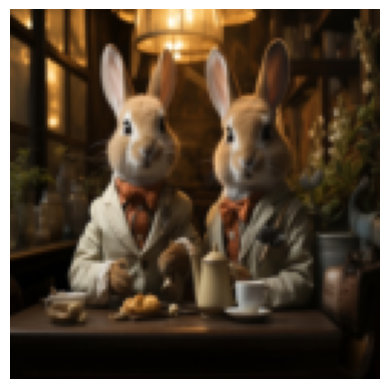

In [78]:
img_tensor = dataset[471]

# If it's a tuple like (tensor, label), unpack it:
if isinstance(img_tensor, tuple):
    img_tensor, label = img_tensor

# Convert from (C, H, W) to (H, W, C)
img = img_tensor.permute(1, 2, 0).numpy()

# Plot
plt.imshow(img)
plt.axis("off")
plt.show()


*Checking for GPU Availability*

This code checks if a CUDA-enabled GPU is available and sets the `device` accordingly. If no GPU is available, it defaults to the CPU.

In [79]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


**2. Data Preparation**

In [80]:
# --- 3. Split into train/test ---
train_size = int(0.8 * len(dataset))  # 80% train, 20% test
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# --- 4. Wrap in DataLoaders ---
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

**3. Neural Network Model**

In [81]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(in_features=124*124*64, out_features=128)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=128, out_features=6)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.flat(x)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)
model

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=984064, out_features=128, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)

**4. Loss & Optimizer**

In [82]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.02)

**5. Training loop**

In [83]:
for epoch in range(5):  # Train for 5 epochs
    running_loss = 0.0
    for images, labels in train_loader:
        # Move images and labels to the device
        images = images.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/5], Loss: {running_loss / len(train_loader):.4f}')

Epoch [1/5], Loss: 1.8518
Epoch [2/5], Loss: 1.7776
Epoch [3/5], Loss: 1.7520
Epoch [4/5], Loss: 1.7207
Epoch [5/5], Loss: 1.6836


**6. Evaluation on the test set**

In [84]:
correct = 0
total = 0
with torch.no_grad():  # Disable gradient calculation for evaluation
    for images, labels in test_loader:
        # Move images and labels to the device
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')

Accuracy: 26.32%


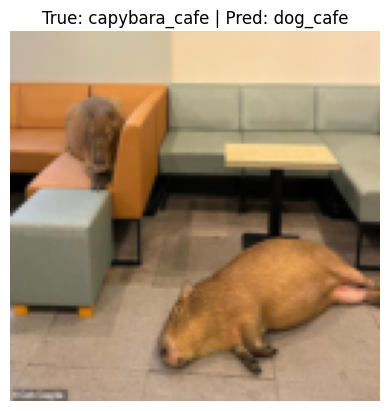

In [96]:
# Get one batch from test_loader
images, labels = next(iter(test_loader))

# Move to device
images = images.to(device)
labels = labels.to(device)

# Get predictions
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Pick the nth image in the batch
n=11 # n=4,5 top
img = images[n].cpu().permute(1, 2, 0).numpy()  # (C,H,W) -> (H,W,C)
true_label = dataset.classes[labels[n].item()]
pred_label = dataset.classes[predicted[n].item()]

# Show the image
plt.imshow(img)
plt.axis("off")
plt.title(f"True: {true_label} | Pred: {pred_label}")
plt.show()